In [1]:
from func import *
with open('graph/multimodal_graph.gpickle', 'rb') as f:
    # Carregar o grafo do metro
    G_Multi = pickle.load(f)

In [2]:
# Definir data/hora e nós de origem/destino
start_datetime = datetime(2025, 12, 23, 8, 30, 0) # (ano, mês, dia, hora, minuto, segundo)

In [3]:
# Definir coordenadas de início e fim (Caso queira escolher pelo mapa, https://geojson.io/#map=9.43/40.9863/-8.3466)
START_COORDS = (41.1584, -8.6291)  # Cordenadas do ponto de início: (Latitude, Longitude)
END_COORDS   = (41.1404, -8.6118)  # Cordenadas do ponto de fim: (Latitude, Longitude)

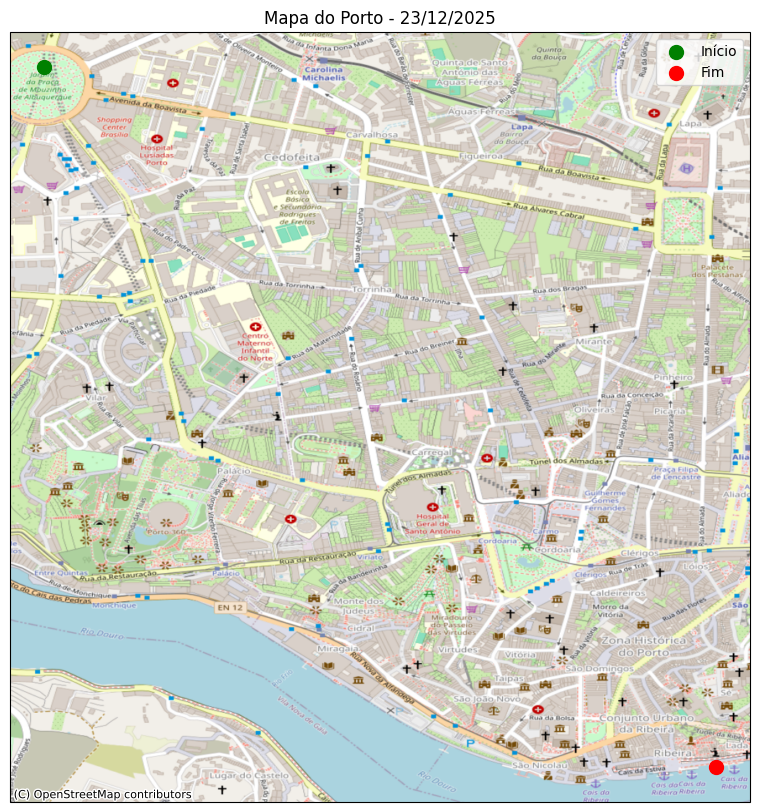

In [4]:
# Visualizar os pontos no mapa usando Cartopy e Contextily
fig = plt.figure(figsize=(10, 10))

# Definir a projeção do gráfico como PlateCarree
ax = plt.axes(projection=ccrs.PlateCarree())

# Marcar Ponto de Início (Verde)
ax.scatter(START_COORDS[1], START_COORDS[0], color='green', s=100, 
           transform=ccrs.PlateCarree(), label='Início', zorder=5)

# Marcar Ponto de Fim (Vermelho)
ax.scatter(END_COORDS[1], END_COORDS[0], color='red', s=100, 
           transform=ccrs.PlateCarree(), label='Fim', zorder=5)

# Adicionar Legenda
ax.legend(loc='upper right')
ax.set_title(f"Mapa do Porto - {start_datetime.strftime('%d/%m/%Y')}")

# Adicionar Basemap
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()


Executando NSGA-III com 3 indivíduos por 50 gerações...
Gerando 3 caminhos iniciais com pesos variados...
Inicialização concluída. 1 caminhos únicos gerados.
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        3 |      1 |             - |             -
     2 |        6 |      2 |  1.0000000000 |         ideal
     3 |        9 |      2 |  0.000000E+00 |             f
     4 |       12 |      2 |  0.000000E+00 |             f
     5 |       15 |      2 |  0.000000E+00 |             f
     6 |       18 |      2 |  0.1302671187 |         ideal
     7 |       21 |      2 |  0.000000E+00 |             f
     8 |       24 |      2 |  0.000000E+00 |             f
     9 |       27 |      2 |  0.0292993533 |         nadir
    10 |       30 |      2 |  0.000000E+00 |             f
    11 |       33 |      2 |  0.0132752153 |         ideal
    12 |       36 |      2 |  0.000000E+00 |             f
    13 |       39 |      2 |  0.000000E+00 |             f
    14 |       4

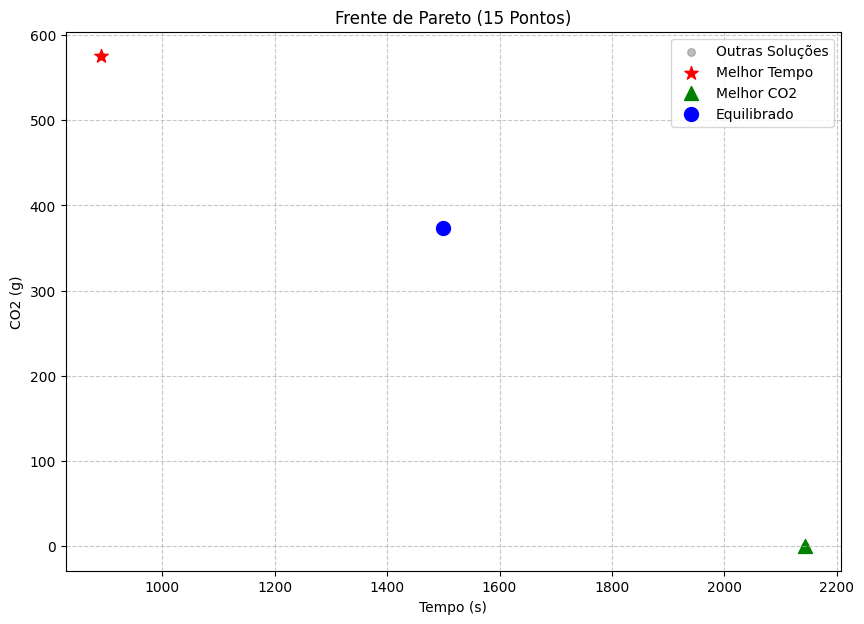

--------------------------------------------------
1. Melhor Tempo: 891s | CO2: 575.20g
2. Equilibrado : 1500s | CO2: 373.52g
3. Melhor CO2  : 2144s | CO2: 0.00g
--------------------------------------------------


In [5]:
# Configuração e execução do NSGA-III
source_node = NearestGraphNode(G_Multi, START_COORDS)
target_node = NearestGraphNode(G_Multi, END_COORDS)

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=2)
sampling = GraphSampling(G_Multi, source_node, target_node, start_datetime)
crossover = PathCrossover(prob=0.8)
mutation = PathMutation(G_Multi, prob=0.3)

algorithm = NSGA3(
    pop_size=len(ref_dirs),
    ref_dirs=ref_dirs,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=False 
)

problem = RoutingProblem(G_Multi, source_node, target_node)

print(f"Executando NSGA-III com {len(ref_dirs)} indivíduos por 50 gerações...")

res = minimize(problem,
               algorithm,
               termination=('n_gen', 50), 
               seed=1,
               verbose=True)

print(f"Terminado. Soluções encontradas: {len(res.F)}")

F = res.F 
X = res.X 

# Analisar e Visualizar Resultados
idx_time = int(np.argmin(F[:, 0]))
idx_co2 = int(np.argmin(F[:, 1]))
sorted_indices = np.argsort(F[:, 0])
idx_balanced = int(sorted_indices[len(sorted_indices) // 2])

# Plotar a Frente de Pareto destacando os 3 pontos
plt.figure(figsize=(10, 7))
plt.scatter(F[:, 0], F[:, 1], c='gray', s=30, alpha=0.5, label='Outras Soluções')
plt.scatter(F[idx_time, 0], F[idx_time, 1], c='red', s=100, marker='*', label='Melhor Tempo')
plt.scatter(F[idx_co2, 0], F[idx_co2, 1], c='green', s=100, marker='^', label='Melhor CO2')
plt.scatter(F[idx_balanced, 0], F[idx_balanced, 1], c='blue', s=100, marker='o', label='Equilibrado')

plt.title("Frente de Pareto (15 Pontos)")
plt.xlabel("Tempo (s)")
plt.ylabel("CO2 (g)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Imprimir detalhes
print("-" * 50)
print(f"1. Melhor Tempo: {F[idx_time, 0]:.0f}s | CO2: {F[idx_time, 1]:.2f}g")
print(f"2. Equilibrado : {F[idx_balanced, 0]:.0f}s | CO2: {F[idx_balanced, 1]:.2f}g")
print(f"3. Melhor CO2  : {F[idx_co2, 0]:.0f}s | CO2: {F[idx_co2, 1]:.2f}g")
print("-" * 50)

def a_extract_path(x):
    # x pode ser: lista de nós, ndarray de objeto com shape (1,), ou escalar
    if isinstance(x, np.ndarray):
        if x.ndim == 0:
            x = x.item()
        elif x.ndim == 1 and x.size == 1:
            x = x[0]
    # Se for escalar inteiro, embrulhar em lista para evitar erros de indexação
    if isinstance(x, (int, np.integer)):
        x = [int(x)]
    return x


 Rota com melhor tempo:

📍 DETALHES DO ITINERÁRIO
🚶 Caminhar
   De:   5322898678
   Até:  428217482
   Dura: 141.9s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   428217482
   Até:  B-BCM2
   Dura: 14.8s | CO2: 0.00g
   ---
🚌 Apanhar Autocarro 
   De:   B-BCM2
   Até:  B-ELVG1
   Dura: 627.0s | CO2: 575.20g
   ---
🚶 Caminhar
   De:   B-ELVG1
   Até:  2206263822
   Dura: 12.6s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   2206263822
   Até:  10718812202
   Dura: 94.6s | CO2: 0.00g
   ---



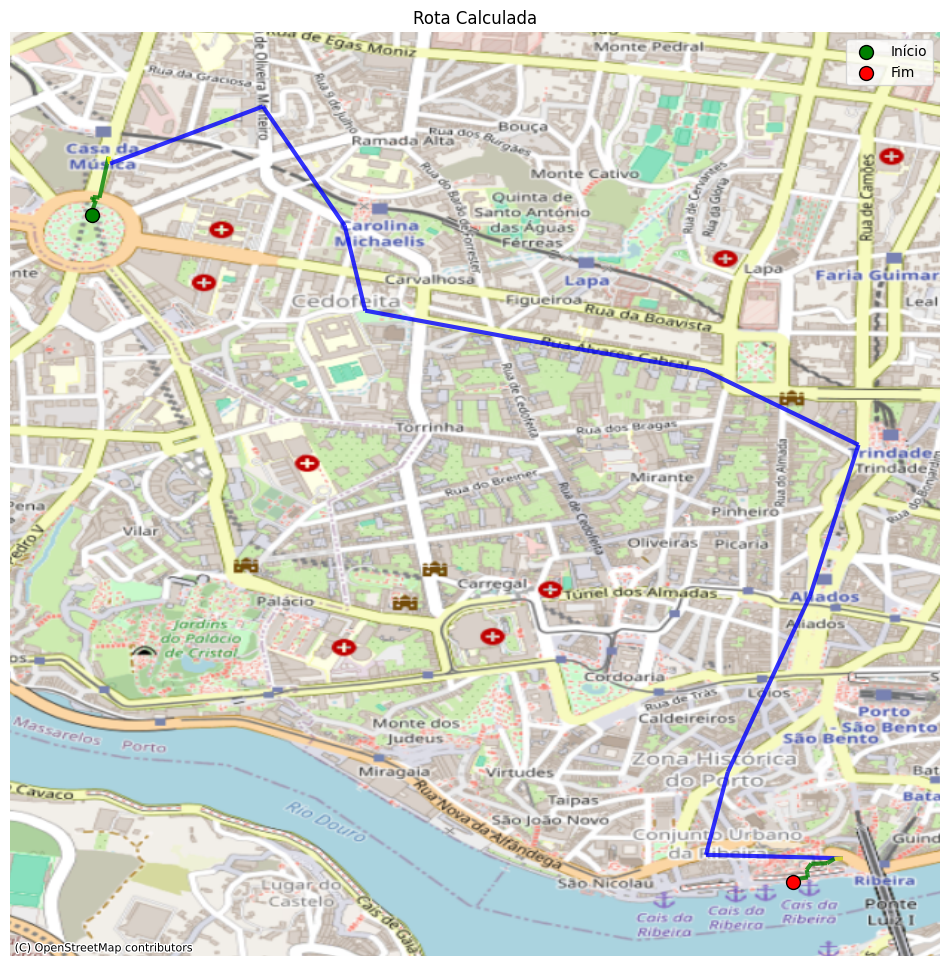

In [6]:
print("\n Rota com melhor tempo:")
path_time = a_extract_path(X[idx_time])
print_detailed_itinerary(G_Multi, path_time) 
PlotPath(G_Multi, path_time)


 Rota mais ecologica (CO2):

📍 DETALHES DO ITINERÁRIO
🚶 Caminhar
   De:   5322898678
   Até:  10718812202
   Dura: 2144.1s | CO2: 0.00g
   ---



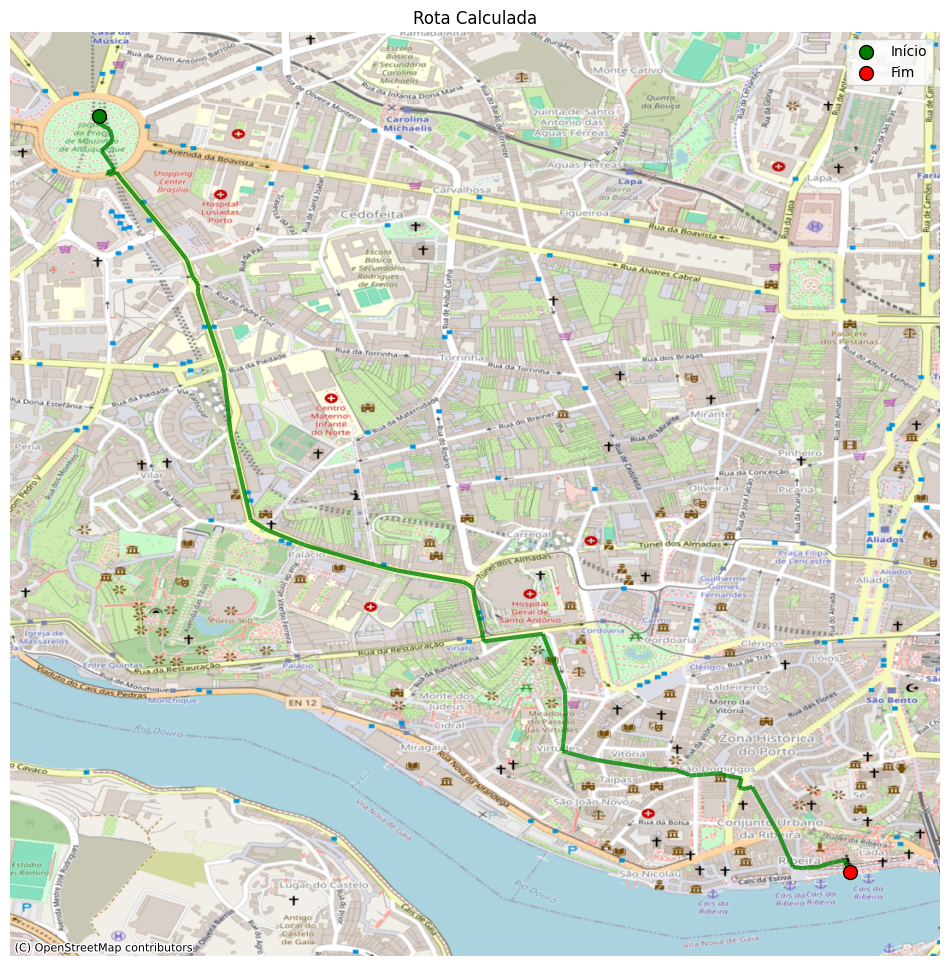

In [7]:
print("\n Rota mais ecologica (CO2):")
path_co2 = a_extract_path(X[idx_co2])
print_detailed_itinerary(G_Multi, path_co2) 
PlotPath(G_Multi, path_co2)


 Rota equilibrada:

📍 DETALHES DO ITINERÁRIO
🚶 Caminhar
   De:   5322898678
   Até:  428217482
   Dura: 141.9s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   428217482
   Até:  B-BCM2
   Dura: 14.8s | CO2: 0.00g
   ---
🚌 Apanhar Autocarro 
   De:   B-BCM2
   Até:  B-TRD5
   Dura: 408.0s | CO2: 357.28g
   ---
🚶 Caminhar
   De:   B-TRD5
   Até:  452682249
   Dura: 11.4s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   452682249
   Até:  7134786669
   Dura: 301.5s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   7134786669
   Até:  T-5766
   Dura: 7.5s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   T-5766
   Até:  T-5778
   Dura: 60.0s | CO2: 16.24g
   ---
🚶 Caminhar
   De:   T-5778
   Até:  10581945312
   Dura: 4.2s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   10581945312
   Até:  2206263822
   Dura: 430.4s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   2206263822
   Até:  2206263822
   Dura: 25.2s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   2206263822
   Até:  10718812202
   Dura: 94.6s | CO2: 0.00g
   ---



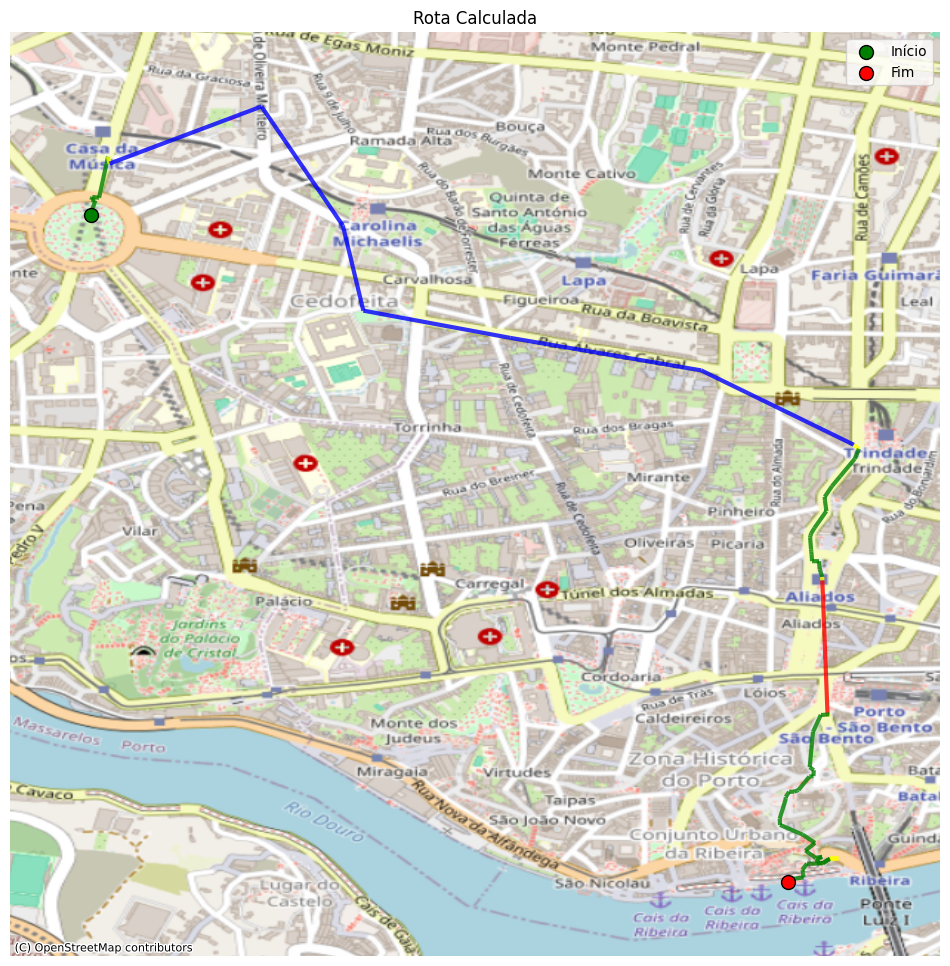

In [8]:
print("\n Rota equilibrada:")
path_balanced = a_extract_path(X[idx_balanced])
print_detailed_itinerary(G_Multi, path_balanced) 
PlotPath(G_Multi, path_balanced)
